# 6-ое домашнее задание - Методы оптимизации в машинном обучении

**Выполнила**: Балакирева Дарья Сергеевна, НПМбд-01-19

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import oracles
import optimization
import presubmit_tests as prt
from plot_trajectory_2d import plot_levels, plot_trajectory
from sklearn.datasets import load_svmlight_file

Проверка тестов:

In [2]:
prt.test_python3()
prt.test_QuadraticOracle()
prt.test_log_reg_usual()
prt.test_log_reg_oracle_calls()
prt.test_grad_finite_diff_1()
prt.test_grad_finite_diff_2()
prt.test_hess_finite_diff_1()
prt.test_hess_finite_diff_2()
prt.test_line_search()
prt.test_gd_basic()
prt.test_newton_basic()
prt.test_newton_1d()
prt.test_newton_fail()

Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]


# 1. Эксперимент: Траектория градиентного спуска на квадратичной функции

Как отличается поведение метода в зависимости от числа обусловленности функции, выбора начальной точки и стратегии выбора шага (константная стратегия, Армихо, Вульф)?

In [100]:
x_start = np.array([[3., 4.], [1., -2.], [-1., -1.]])
methods = [{'method': 'Constant', 'c': 0.6}, {'method': 'Constant', 'c': 0.02}, 
           {'method': 'Armijo', 'alpha_0': 1.0, 'c1':0.7}, {'method':'Armijo', 'alpha_0':100.0, 'c1':0.9}, 
           {"method":'Wolfe', 'c1':0.0001, 'c2':0.8, 'alpha_0':1.0}, {"method":'Wolfe', 'c1':0.1, 'c2':0.95, 'alpha_0':100.0}]

## Хорошо обусловленная матрица

In [49]:
A = np.array([[1.0, 0.], [0., 2.0]])
b = np.zeros(2)
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A)))

Число обусловленности: 2.5000000000000004


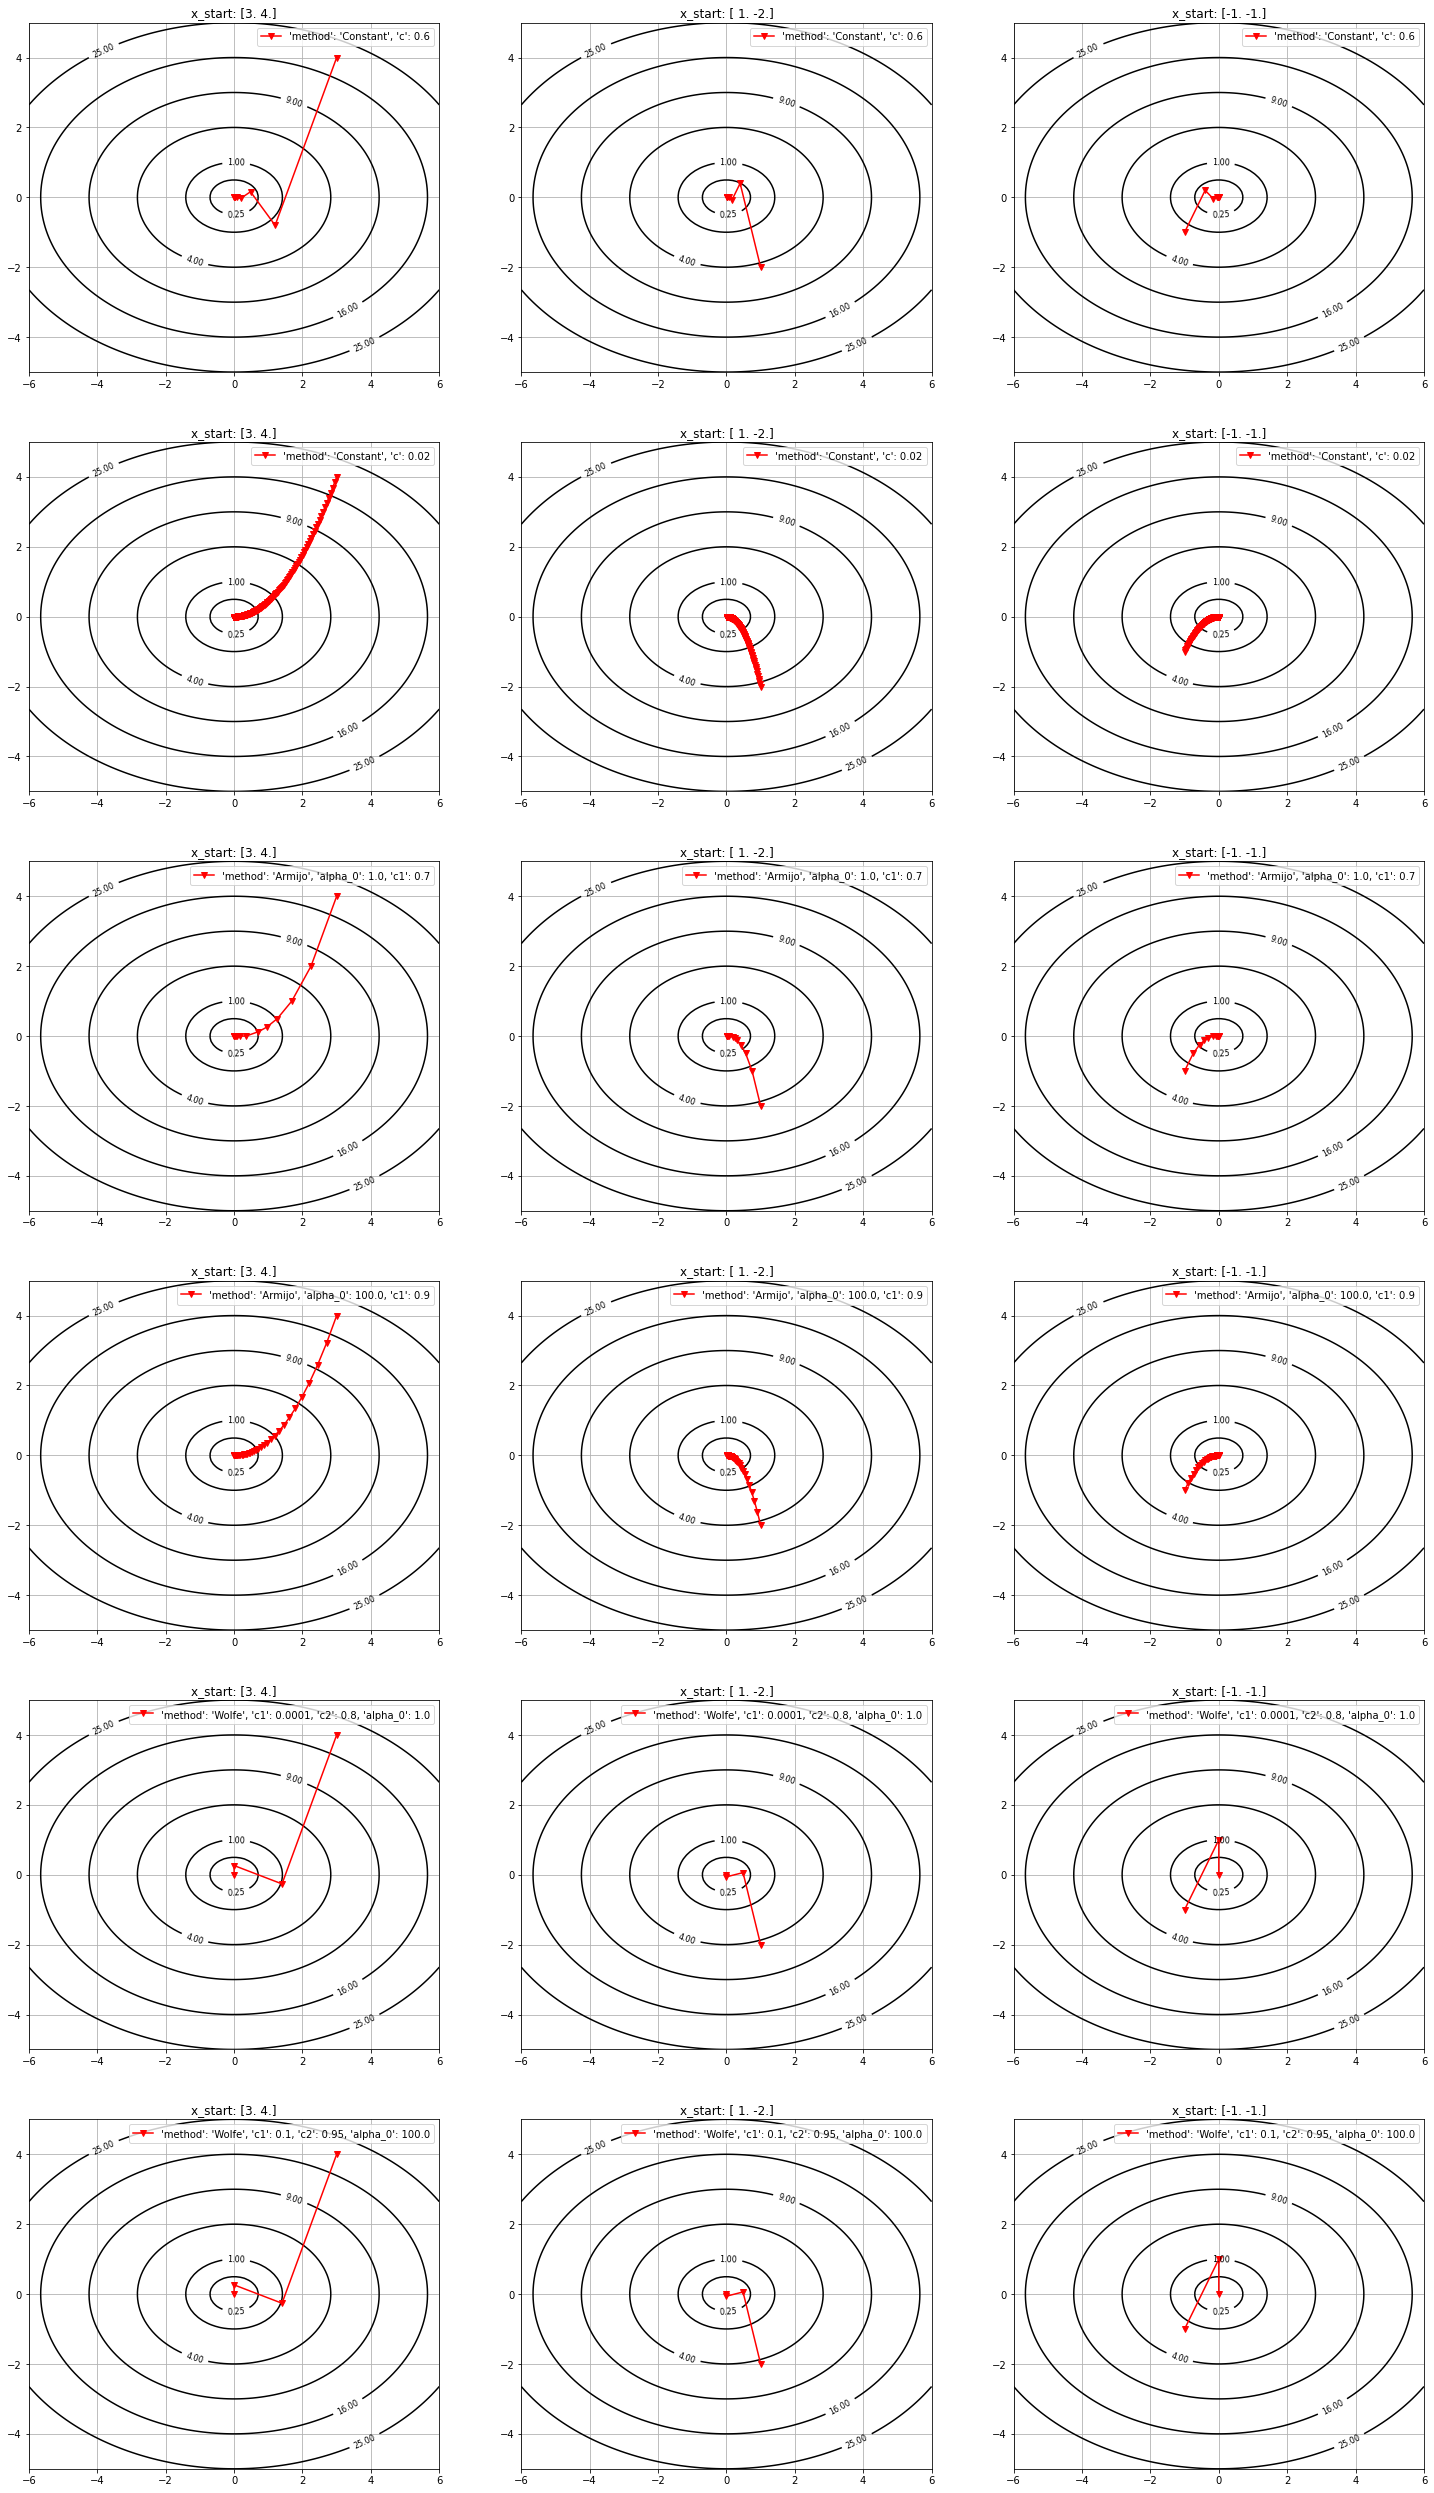

In [53]:
fig, ax = plt.subplots(len(methods), len(x_start), figsize = (25,45))
for i in range(len(methods)):
    for j in range(len(x_start)):
        [x_s, msg, history] = optimization.gradient_descent(oracle, x_start[j], line_search_options = methods[i], trace=True)
        plot_levels(oracle.func, ax[i][j])
        plot_trajectory(oracle.func, history['x'], ax[i][j], label=str(methods[i])[1:-1])
        ax[i][j].set_title("x_start: " + str(x_start[j]))
        ax[i][j].legend()

## Плохо обусловленная матрица

In [101]:
A = np.array([[1., -1.2],[-1.2, 2.001]])
b = np.array([2., 2.4])
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A)))

Число обусловленности: 14.05347771836007


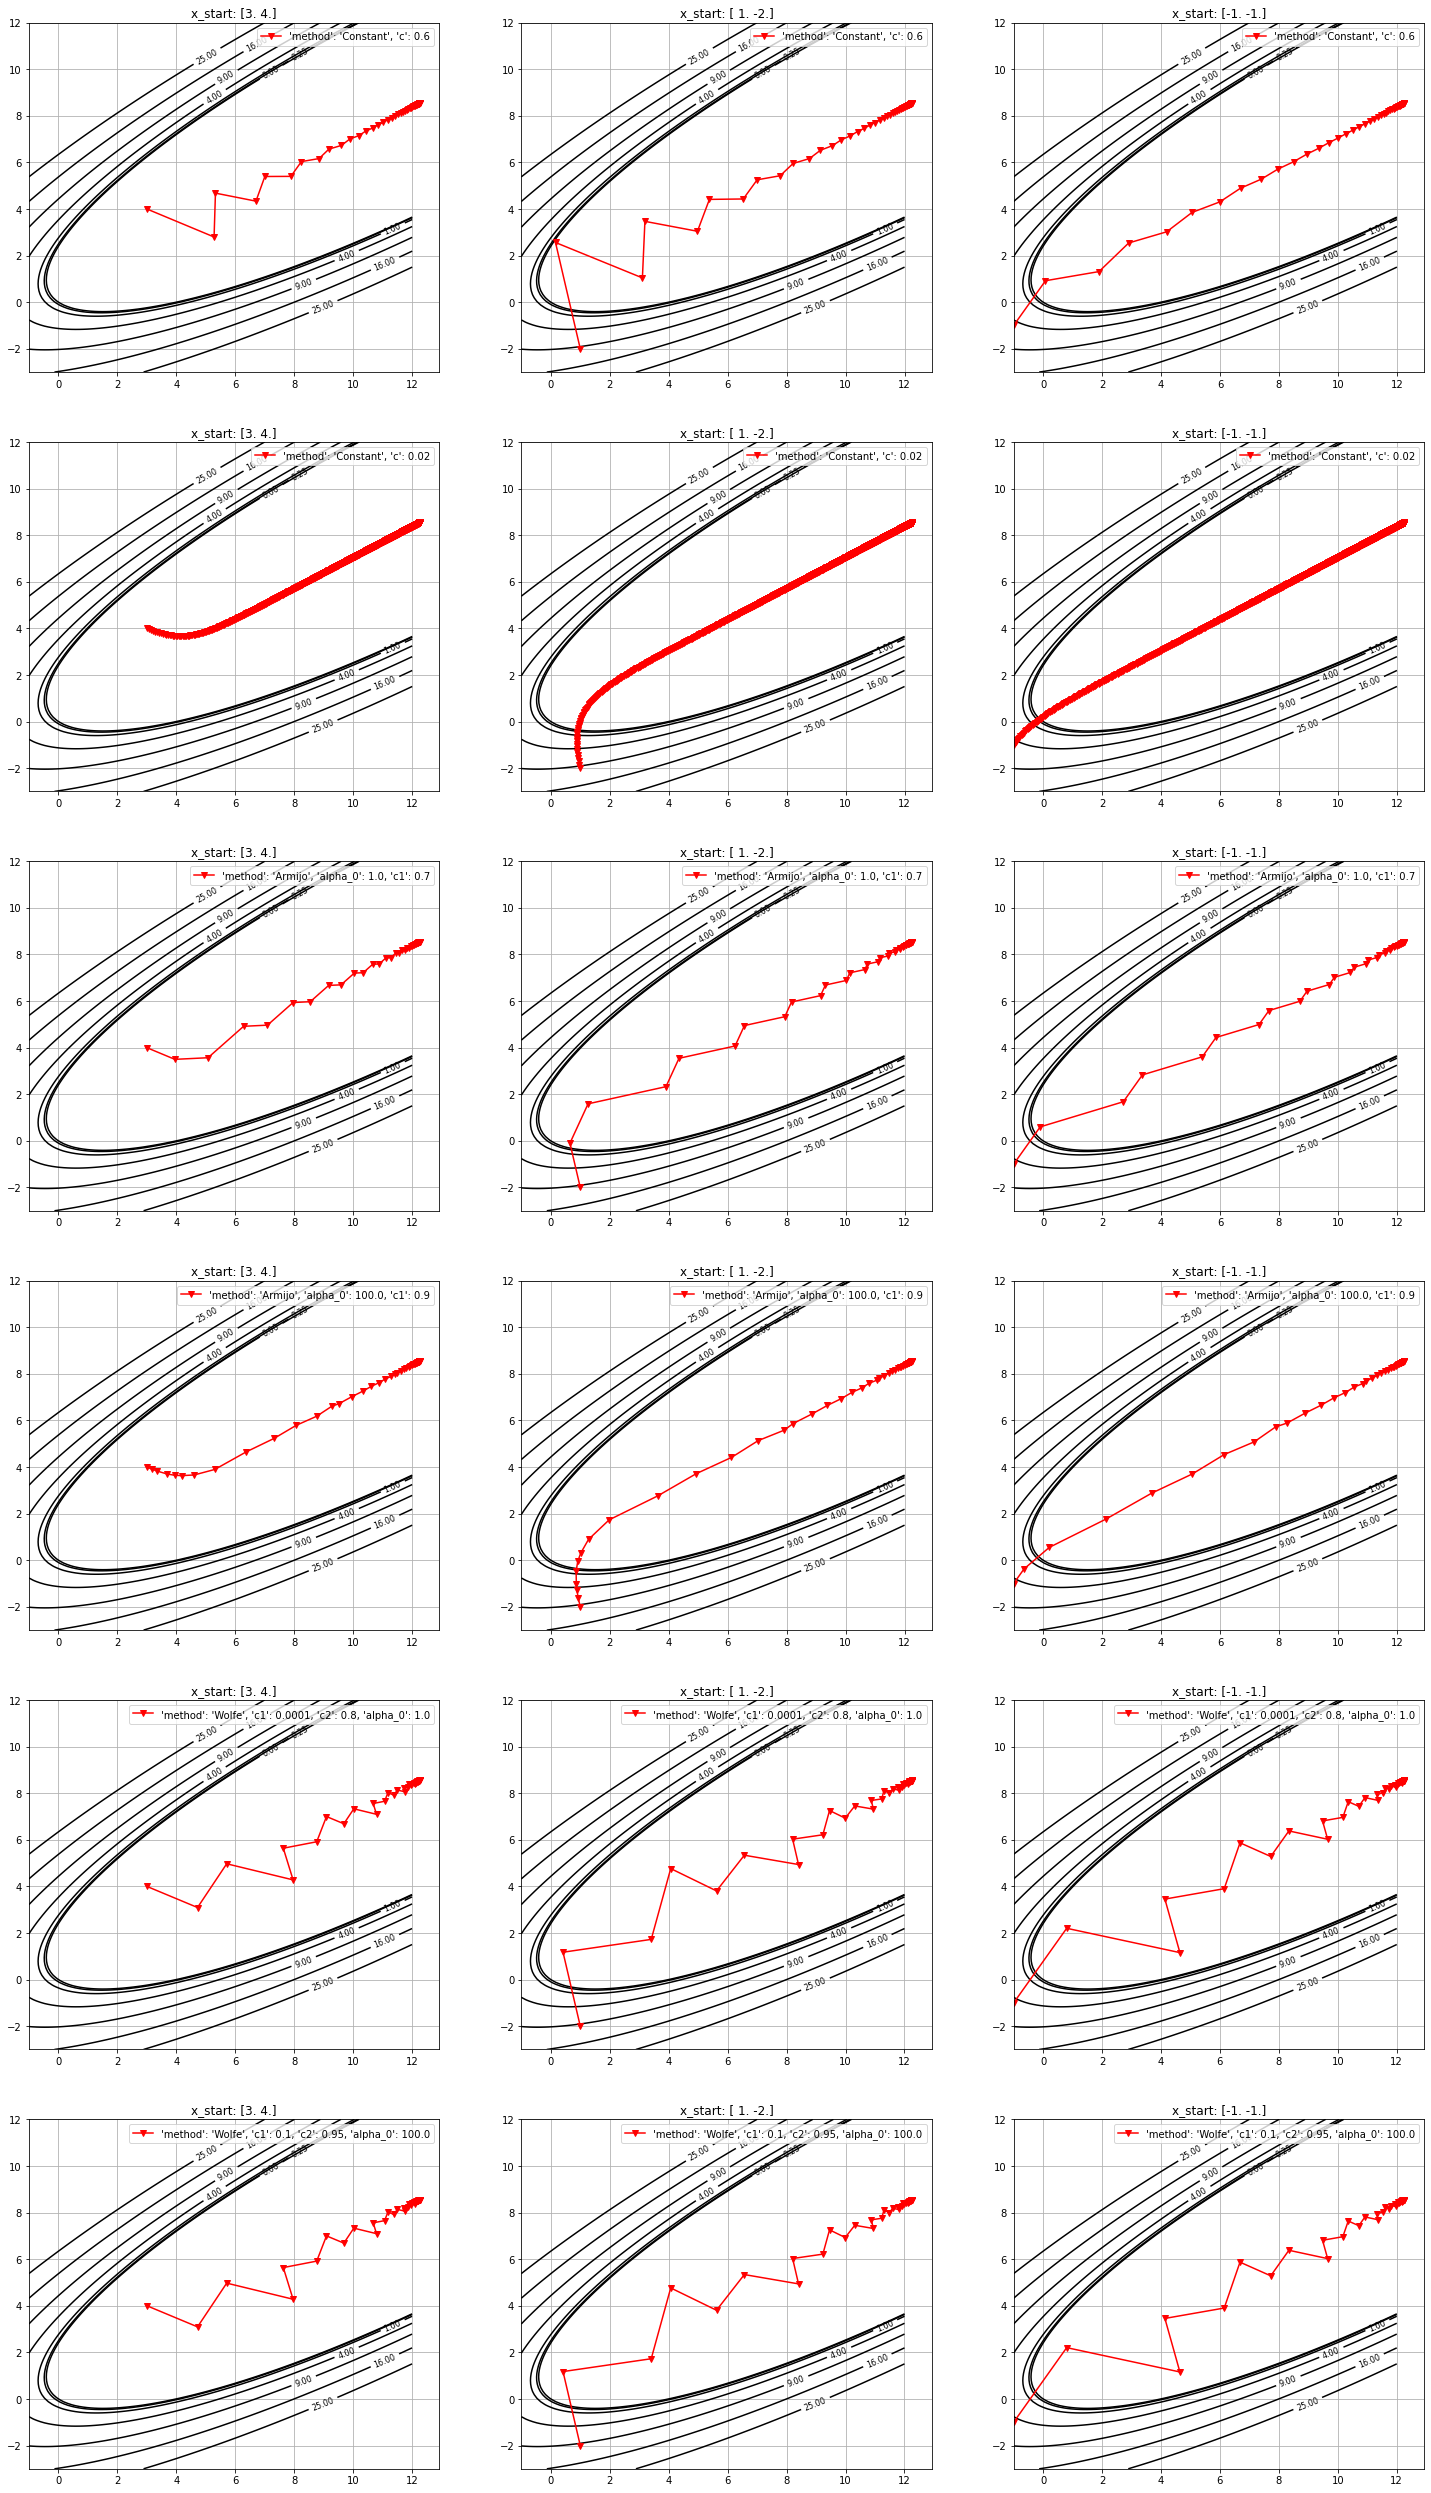

In [103]:
fig, ax = plt.subplots(len(methods), len(x_start), figsize = (25,45))
for i in range(len(methods)):
    for j in range(len(x_start)):
        [_, _, history] = optimization.gradient_descent(oracle, x_start[j], line_search_options = methods[i], trace=True)
        plot_levels(oracle.func, ax[i][j], xrange=[-1,12], yrange=[-3,12])
        plot_trajectory(oracle.func, history['x'], ax[i][j], label=str(methods[i])[1:-1])
        ax[i][j].set_title("x_start: " + str(x_start[j]))
        ax[i][j].legend()

**Ответ:** Лучше всего себя показал метод Вульфа. При плохо обусловленной матрице часто наблюдается зигзагообразность.

# 2. Эксперимент: Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

Исследуйте, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих двух параметров: 1) числа обусловленности κ ≥ 1 оптимизируемой функции и 2) размерности
пространства n оптимизируемых переменных.

In [79]:
k_r = np.arange(1, 101, 10)
options = [(10, 'g'), (100, 'b'), (1000, 'r')]
methods = [{'method': 'Constant', "c":0.01}, 
           {'method':'Armijo', 'alpha_0':1.0, 'c1':0.96}, 
           {"method":'Wolfe', 'c1':0.001, 'c2':0.7, 'alpha_0':1.0}]

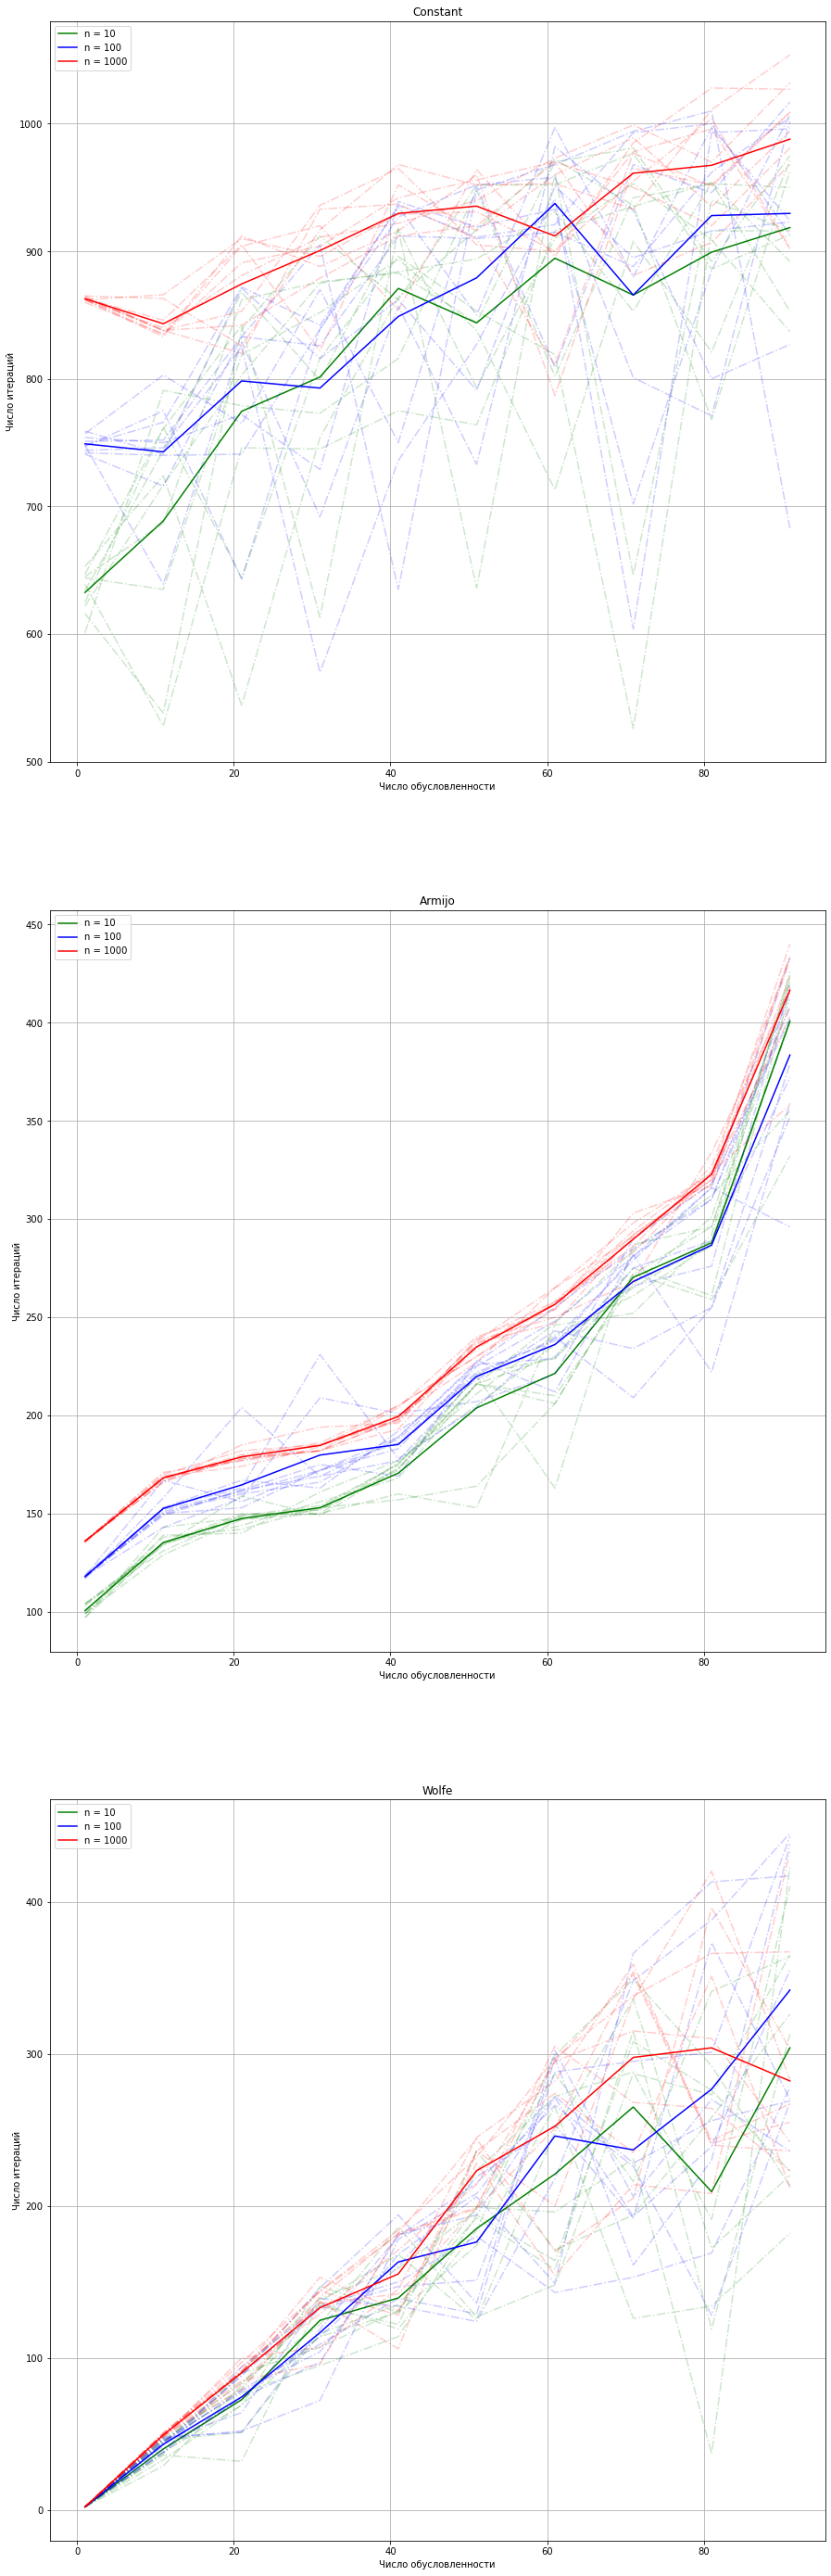

In [81]:
fig, ax = plt.subplots(3, 1, figsize=(15,50))

for i in range(len(methods)):
    for option in options:
        I = np.zeros(len(k_r))
        for j in range(10):
            itera = []
            for k in k_r:
                diag = np.random.uniform(1, k, option[0])
                diag[0] = 1.; diag[-1] = k
                A = scipy.sparse.diags(diag)
                b = np.random.rand(option[0])*k
                oracle = oracles.QuadraticOracle(A, b)
                _, _, history = optimization.gradient_descent(oracle, np.ones(option[0]), 
                                                              line_search_options = methods[i], trace=True)
                itera.append(len(history['func']))
            I += np.array(itera)
            ax[i].plot(k_r, itera, color=option[1], linestyle='-.', alpha=0.2)
        ax[i].plot(k_r, I/10, color=option[1], label=('n = '+str(option[0])))
        ax[i].legend()
        ax[i].set_xlabel("Число обусловленности")
        ax[i].set_ylabel("Число итераций")
        ax[i].set_title(methods[i]['method'])
        ax[i].grid()

**Вывод:** Число итераций растёт практически линейно вместе с числом обусловленности, а размерность не имеет сильного влияния.

# 3. Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

Сравнить методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на реальных данных.

В качестве реальных данных используйте следующие три набора с сайта LIBSVM3: w8a, gisette и real-sim. Коэффициент регуляризации взять стандартным образом: λ = 1=m.

Параметры обоих методов взять равными параметрам по умолчанию. Начальную точку выбрать x0 = 0.
Построить графики сходимости следующих двух видов:
- Зависимость значения функции от реального времени работы метода.
- Зависимость относительного квадрата нормы градиента $\vert\vert \nabla f(x_k) \vert\vert_2^2 / \vert\vert \nabla f(x_0) \vert\vert_2^2$ (в логарифмической шкале) против реального времени работы.

In [105]:
A1, b1 = load_svmlight_file('данные/w8a.txt')
A2, b2 = load_svmlight_file('данные/gisette_scale.bz2')
A3, b3 = load_svmlight_file('данные/real-sim.bz2')

In [106]:
data = [(A1, b1, "w8a"), (A2, b2, "gisette_scale"), (A3, b3, "real-sim")]

In [104]:
def time_graphic(item):
    rcoef = 1 / len(item[1])
    oracle = oracles.create_log_reg_oracle(item[0], item[1], rcoef)
    _, _, history_g = optimization.gradient_descent(oracle, np.zeros(item[0].shape[1]), trace=True)
    _, _, history_n = optimization.newton(oracle, np.zeros(item[0].shape[1]), trace=True)

    ax[0].plot(history_g['time'], history_g['func'], label="Метод градиентного спуска")
    ax[0].plot(history_n['time'], history_n['func'], label="Метод Ньютона")
    ax[0].set_xlabel('Время работы')
    ax[0].set_ylabel('Значение функции')
    ax[0].legend()
    ax[0].set_title(item[2])
    ax[0].grid()

    ax[1].plot(history_g['time'], np.array(history_g['grad_norm'])**2 / (history_g['grad_norm'][0]**2), label="Метод градиентного спуска")
    ax[1].plot(history_n['time'], np.array(history_n['grad_norm'])**2 / (history_n['grad_norm'][0]**2), label="Метод Ньютона")
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Время работы')
    ax[1].set_ylabel(r'$\vert\vert \nabla f(x_k) \vert\vert_2^2 / \vert\vert \nabla f(x_0) \vert\vert_2^2$')
    ax[1].legend()
    ax[1].set_title(item[2])
    ax[1].grid()

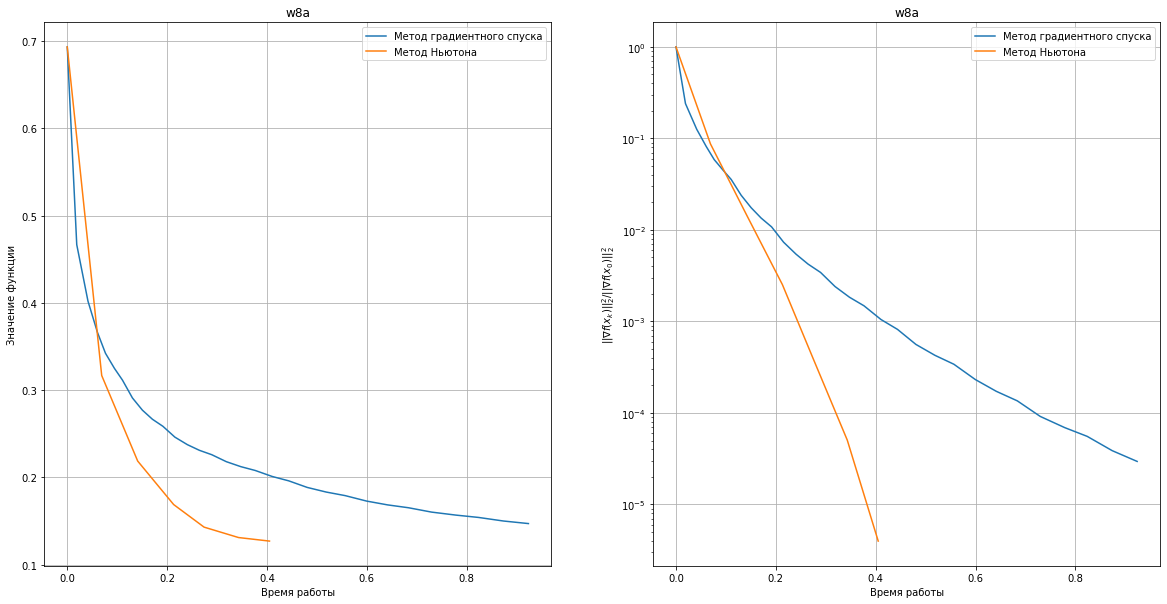

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
time_graphic(data[0])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
visualize_time(data[1])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
visualize_time(data[2])

**Нюанс:** мой компьютер не потянул графики с gisette и real-sim :(

**Вывод:** Метод градиента работает быстрее в начале, однако для малой заданной точности сильно замедляется.